# Flora Prepper Model Evaluation
## Initialize the environment

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.data.make_fna import *
from src.data.make_bc import *
from src.data.make_budds import *
from src.models.run_model import *
from src.visualization.visualize import *
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

## Import the data

In [2]:
fna = make_fna_data_frame(fna_filepath="../data/external/fna_keys.csv", frac_to_sample=0.1, balance_categories=True,
                          categories_to_keep=["key", "morphology", "taxon_identification", "distribution"])
bc = make_bc_data_frame(bc_filepath="../data/external/eflora-bc-partial.csv",
                        frac_to_sample=0.15, balance_categories=True)
budds = make_budds_data_frame(budds_file_path="../data/external/buddsfloraofcana00otta_djvu.xml", frac_to_sample=1,
                              balance_categories=True)
flora_data_frame = pd.concat([fna, bc, budds], keys=['fna', 'bc', 'budds'], names=['Dataset name', 'Row ID'])

/Users/jocelynpender/miniconda3/envs/flora-prepper/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


## Visualize the data
### Visualize counts of training datasets

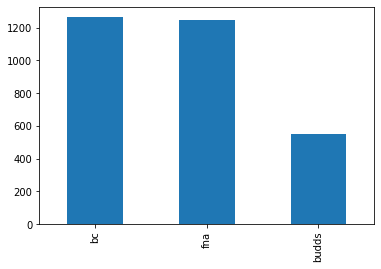

In [3]:
flora_data_frame = flora_data_frame.reset_index()
flora_data_frame['Dataset name'].value_counts().plot.bar()
plt.show()

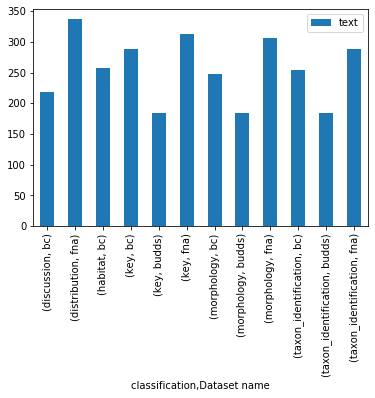

In [34]:
flora_data_frame[['classification', 'Dataset name', 'text']].groupby(['classification', 'Dataset name']).count().plot.bar()


### View a word cloud for all text data 
Text is processed using the same custom (bare-bones) tokenizer and stopwords used to train the model. 


In [ ]:
tokenized_stop_words = prepare_stop_words(custom_stop_words=["unknown", "accepted", "synonym",
                                                             "basionym", "source",
                                                             "note", "notes"])  # Find a way to keep numbers and elipses!
text = " ".join(text_string for text_string in flora_data_frame.text)
visualize_words(text, tokenized_stop_words)

### Generate word clouds by classification.
Are there any noticeable differences between the words used most frequently between the classifications?

In [ ]:
taxon_identification = " ".join(text_string for text_string in flora_data_frame[flora_data_frame.classification == "taxon_identification"].text)
morphology = " ".join(text_string for text_string in flora_data_frame[flora_data_frame.classification == "morphology"].text)
key = " ".join(text_string for text_string in flora_data_frame[flora_data_frame.classification == "key"].text)
habitat = " ".join(text_string for text_string in flora_data_frame[flora_data_frame.classification == "habitat"].text)

Taxon identification

In [ ]:
visualize_words(taxon_identification, tokenized_stop_words)

Morphology

In [ ]:
visualize_words(morphology, tokenized_stop_words)

Keys

In [ ]:
visualize_words(key, tokenized_stop_words)

Habitat

In [ ]:
visualize_words(habitat, tokenized_stop_words)


### Word clouds by flora source
Are there differences between training sets in the most commonly used words?

In [ ]:
bc_text = " ".join(text_string for text_string in bc.text if text_string not in tokenized_stop_words)
budds_text = " ".join(text_string for text_string in budds.text if text_string not in tokenized_stop_words)
fna_text = " ".join(text_string for text_string in fna.text if text_string not in tokenized_stop_words)


BC

In [ ]:
visualize_words(bc_text, tokenized_stop_words)

FNA

In [ ]:
visualize_words(fna_text, tokenized_stop_words)

Budds

In [ ]:
visualize_words(budds_text, tokenized_stop_words)


### What happens to the key and morphology classifications if we implement stricter word tokenization?

Key

In [ ]:
word_cloud_key = WordCloud(stopwords=tokenized_stop_words, 
                      background_color="white", collocations=False).process_text(key)
fdist_key = FreqDist(word_cloud_key)
fdist_key.plot(30,cumulative=False)
plt.show()

Morphology

In [ ]:
word_cloud_morphology = WordCloud(stopwords=tokenized_stop_words, 
                      background_color="white", collocations=False).process_text(morphology)
fdist_morphology = FreqDist(word_cloud_morphology)
fdist_morphology.plot(30,cumulative=False)
plt.show()

### Visualize distinctive words using tf-idf


In [ ]:
custom_vec = TfidfVectorizer(lowercase=True, tokenizer=flora_tokenizer, stop_words=tokenized_stop_words, ngram_range=(1, 1))
text_counts = custom_vec.fit_transform(flora_data_frame['text'])  # Build TF-IDF Matrix

scores = zip(custom_vec.get_feature_names(), np.asarray(text_counts.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
#for item in sorted_scores:
 #   print("{0:10} Score: {1}".format(item[0], item[1]))
    
sorted_scores_df = pd.DataFrame(sorted_scores, columns=['word', 'score']).iloc[:50]
sorted_scores_df.plot.bar(x='word', y='score')
plt.show()

## Run a DTM based model and a TFIDF based model and review accuracy

In [ ]:
# ==== DTM =====
dtm_text_counts = build_dtm_text_counts(flora_tokenizer, tokenized_stop_words, flora_data_frame)
X_test, predictions = run_model(dtm_text_counts, flora_data_frame)

# ==== TFIDF =====
tfidf_text_counts = build_tfidf_text_counts(flora_tokenizer, tokenized_stop_words, flora_data_frame)
X_test, predictions = run_model(tfidf_text_counts, flora_data_frame)


#### View incorrectly classified statements

In [ ]:
results = zip(X_test, predictions)
print(tuple(results))

In [ ]:
# Currently not working

#for item, labels in zip(X_test, predictions):
 #   print('%s => %s' % (item, ', '.join(flora_data_frame.classification[x] for x in labels)))

## Run a model based on text length

In [ ]:
# Process text, remove stopwords. Remove empty cells.
length_processed_flora_data_frame = process_length_in_place(flora_data_frame, tokenized_stop_words)


plot = length_processed_flora_data_frame['length'].hist(by=length_processed_flora_data_frame['classification'])
plt.show()

It looks like discussion should be removed from the dataset. It is curiously short in length. This may be an artifact from the bc dataset.

In [ ]:

X_test, predicted = run_model(length_model_sparse, length_processed_flora_data_frame)

In [ ]:
#fig,ax = plt.subplots(figsize=(5,5))
#plt.boxplot(df_train_1.phrase_len)
#plt.show()


To do plots:
classification coloured by source